## Prediction of 50 startups profit

In [22]:
# importing libraries
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf 
startups_data = pd.read_csv('Startups.csv')

In [23]:
startups_data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [3]:
# Analysing data
startups_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [4]:
# Dropping State column as it is a categorical column and is not required for model building
startups_data.drop('State', axis=1, inplace=True)

## Building an initial model

In [5]:
# Renaming the column names (removing spaces and soecial characters) as ols doesn't support the spaces in variable names
startups_data.rename({'Marketing Spend':'Marketing', 'R&D Spend' : 'R_D',}, axis=1, inplace=True)

In [6]:
startups_data.head()

,R_D,Administration,Marketing,Profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


In [7]:
# Building multi linear regression model with all the features
model = smf.ols('Profit~R_D+Administration+Marketing', data = startups_data).fit()

In [8]:
# Displaying the model parameters
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.0
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           4.53e-30
Time:                        12:20:05   Log-Likelihood:                -525.39
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      46   BIC:                             1066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5.012e+04   6572.353      7.626      0.000    3.69e+04    6.34e+04
R_D                0.8057      0.045     17.846      0.000       0.715       0.897
Administration    -0.0268      0.051     -0.526      0.602      -0.130       0.076
Marketing          0.0272      0.016      1.655      0.105      -0.006       0.060
==============================================================================
Omnibus:                       14.838   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.442
Skew:                          -0.949   Prob(JB):                     2.21e-05
Kurtosis:                       5.586   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# Checking features correlation with each other
startups_data.corr()

,R_D,Administration,Marketing,Profit
R_D,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


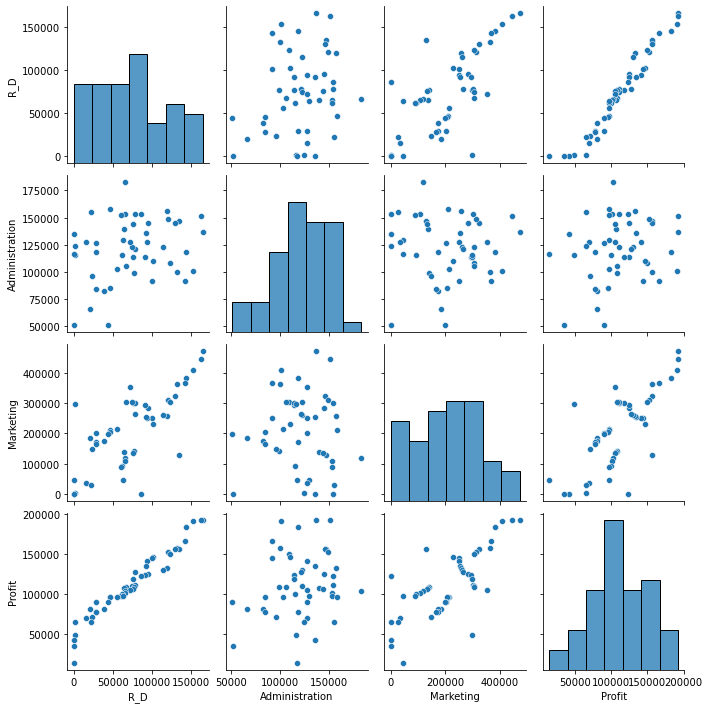

In [10]:
# Plotting scatter plot with each pair of features
sns.pairplot(startups_data)

## Calculating VIF (Variance Inflation Factor)

VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. “

OR

VIF score of an independent variable represents how well the variable is explained by other independent variables.

1. VIF starts at 1 and has no upper limit
2. VIF = 1, no correlation between the independent variable and the other variables
3. VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [11]:
# Building a model for 
rsq_rd = smf.ols('R_D~Marketing+Administration', data=startups_data).fit().rsquared
vif_rd = 1/(1-rsq_rd)

In [12]:
rsq_mkt = smf.ols('Marketing~R_D+Administration', data=startups_data).fit().rsquared
vif_mkt = 1/(1-rsq_mkt)

In [13]:
rsq_adm = smf.ols('Administration~Marketing+R_D', data=startups_data).fit().rsquared
vif_adm = 1/(1-rsq_adm)

In [14]:
df1 = pd.DataFrame({'features':['R_D', 'Marketning','Administration'], 'R_Squared':[rsq_rd, rsq_mkt,rsq_adm], 'VIF':[vif_rd, vif_mkt, vif_adm]})
df1

,features,R_Squared,VIF
0,R_D,0.594962,2.468903
1,Marketning,0.570220,2.326773
2,Administration,0.149002,1.175091


## Another way to calculate VIF 

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

y,X = dmatrices('Profit~R_D+Administration+Marketing',startups_data, return_type='dataframe')

vif = pd.DataFrame()
vif['vif_values'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1]) ] 
vif['features'] = X.columns

vif

,vif_values,features
0,25.338950,Intercept
1,2.468903,R_D
2,1.175091,Administration
3,2.326773,Marketing


## Since VIF is less than 10, we can say that variables are not correlated to each other or there is no problem of collinearity. Hence we can go ahead with the original model which takes all variables into account. Also Rsquared value (accuracy of our model) is 95%

## Building a model without dropping the state 

In [29]:
data = pd.read_csv('Startups.csv')

In [30]:
# Renaming the column names (removing spaces and soecial characters) as ols doesn't support the spaces in variable names
data.rename({'Marketing Spend':'Marketing', 'R&D Spend' : 'R_D',}, axis=1, inplace=True)

In [31]:
data.head()

,R_D,Administration,Marketing,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [33]:
# Converting state to numerical column through Label encoding
from sklearn.preprocessing import LabelEncoder

label_en = LabelEncoder()
data['State'] = label_en.fit_transform(data['State'])
data.head()

,R_D,Administration,Marketing,State,Profit
0,165349.20,136897.80,471784.10,2,192261.83
1,162597.70,151377.59,443898.53,0,191792.06
2,153441.51,101145.55,407934.54,1,191050.39
3,144372.41,118671.85,383199.62,2,182901.99
4,142107.34,91391.77,366168.42,1,166187.94


In [35]:
# Scaling the data through Standard Scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data[:5]


array([[ 2.01641149,  0.56075291,  2.15394309,  1.21267813,  2.01120333],
       [ 1.95586034,  1.08280658,  1.9236004 , -1.21267813,  1.99942997],
       [ 1.75436374, -0.72825703,  1.62652767,  0.        ,  1.98084225],
       [ 1.55478369, -0.09636463,  1.42221024,  1.21267813,  1.77662724],
       [ 1.5049372 , -1.07991935,  1.28152771,  0.        ,  1.35774012]])

In [39]:
# Lets calculate the correlation matirx and VIF matrices to check for the multicoliinearity

scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
scaled_df.head()
scaled_df.corr()


,R_D,Administration,Marketing,State,Profit
R_D,1.000000,0.241955,0.724248,0.104685,0.972900
Administration,0.241955,1.000000,-0.032154,0.011847,0.200717
Marketing,0.724248,-0.032154,1.000000,0.077670,0.747766
State,0.104685,0.011847,0.077670,1.000000,0.101796
Profit,0.972900,0.200717,0.747766,0.101796,1.000000


In [40]:
y,X = dmatrices('Profit~R_D+Administration+Marketing+State',scaled_df, return_type='dataframe')

vif = pd.DataFrame()
vif['vif_values'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1]) ] 
vif['features'] = X.columns

vif

,vif_values,features
0,1.000000,Intercept
1,2.481178,R_D
2,1.175315,Administration
3,2.326780,Marketing
4,1.011281,State


### Safely, since VIF and correlation matrices are in ranges, no two columns are correlated to each other and we can build the model and check the accurcay keepin state in the model.

In [41]:
model = smf.ols('Profit~R_D+Administration+Marketing+State', data = scaled_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     217.2
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           8.51e-29
Time:                        12:55:16   Log-Likelihood:                 4.3223
No. Observations:                  50   AIC:                             1.355
Df Residuals:                      45   BIC:                             10.92
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5.551e-16      0.033  -1.68e-14      1.000      -0.067       0.067
R_D                0.9176      0.052     17.609      0.000       0.813       1.023
Administration    -0.0186      0.036     -0.520      0.606      -0.091       0.054
Marketing          0.0826      0.050      1.637      0.109      -0.019       0.184
State             -0.0005      0.033     -0.014      0.989      -0.067       0.067
==============================================================================
Omnibus:                       14.864   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.542
Skew:                          -0.949   Prob(JB):                     2.10e-05
Kurtosis:                       5.596   Cond. No.                         2.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Both models have same accuracy, 95%. No harm and gain in keeping or dropping the state column